# Анализ оттока клиентов регионального банка

## Описание проекта

### Материалы

[Презентация](https://disk.yandex.ru/i/DEDNweHM9p_Tww)

[Дашборд на выбор](https://public.tableau.com/views/_16647376413540/sheet2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

### Задача

Проанализировать отток клиентов и сформировать рекомендации для их удержания.

### План исследования

1. Подготовить данные
2. Провести исследовательский анализ
3. Проверить статистические гипотезы 
4. Сделать общий вывод и предложить рекомендации   

### Структура данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя;
- `score` — баллы кредитного скоринга;
- `City` — город;
- `Gender` — пол;
- `Age` — возраст;
- `Objects` — количество объектов в собственности;
- `Balance` — баланс на счёте;
- `Products` — количество используемых продуктов: дебетовая карта, кредитная карта, вклад, кредит;
- `CreditCard` — есть ли кредитная карта;
- `Loyalty` — активный или нет: совершает ли клиент целевое действие в заданный промежуток времени;
- `estimated_salary` — предполагаемая заработная плата;
- `Churn` — ушёл или нет.

## Знакомство с данными 

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# загрузка данных
df = pd.read_csv('bank_dataset.csv')

# вывод информации по датасету
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# проверка явных дубликатов
print('Количество дубликатов в датасете -', df.duplicated().sum())

Количество дубликатов в датасете - 0


### Промежуточный вывод

- Датасет состоит из 12 столбцов и 10 тысяч строк,
- Названия колонок не соответствует стилистике,
- В столбце 'Balance' имеются пропуски в данных,
- Типы данных указаны верно,
- Явных дубликатов не обнаружено.

## Предобработка данных

### Переименование столбцов

In [4]:
# приведение к нижнему регистру
df.columns = [x.lower() for x in df.columns]

# разделение нижним подчеркиванием двух и более слов в названии столбцов
df = df.rename(columns={'userid':'user_id', 'creditcard':'credit_card'})

# проверка названий столбцов
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Обработка пропусков в столбце 'Balance'

In [5]:
print('Balance:', \
      '\nКол-во пропусков -', df['balance'].isna().sum(), \
      '\nПроцент пропусков -', round(df['balance'].isna().sum() / len(df) * 100, 2), '%')

Balance: 
Кол-во пропусков - 3617 
Процент пропусков - 36.17 %


Пропущена треть данных в столбце с балансом на счетах клиентов. Предполагаю, что пропуски сформированы специально для учебных целей, однако важно понимать, что в реальных данных это серьезная проблема, о которой нужно срочно сообщать дата инженерам.  Для сохранности параметров распределения заполняемой переменной - математического ожидания и дисперсии - заполним пропуски медианой, а не средним значением, так как столбец с балансом представлен в денежном выражении и подвержен выбросам.

In [6]:
# выбор квартилей для разбивки по классам
df['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

In [7]:
def salary(income):
    
    '''
    Функция для присвоения каждому клиенту класса, в зависимости от предполагаемого дохода.
    Классы формируем на основе квартилей
    '''
    
    if income <= 51000:
        return 'A'
    elif income <= 100000:
        return 'B'
    elif income <= 150000:
        return 'C'
    else:
        return 'D'
    
df['salary_class'] = df['estimated_salary'].apply(salary)

# смотрим распределение классов
df['salary_class'].value_counts(sort=True)

C    2555
A    2500
B    2490
D    2455
Name: salary_class, dtype: int64

In [8]:
# проверка функции
print(salary(10), salary(53000), salary(121000), salary(187000), sep='\n')

A
B
C
D


In [9]:
# заполнение пропусков медианой по сгруппированным классам
df['balance'] = df['balance'].fillna(df.groupby('salary_class')['balance'].transform('median'))

In [10]:
# финальная проверка данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
 12  salary_class      10000 non-null  object 
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


### Промежуточный вывод

- Названия колонок привели в соответствие стилистике Python,
- Разделили клиентов банка на 4 класса по предполагаемой зарплате,
- Пропущенные значения в столбце 'balance' заполнили медианой по принадлежности к классу.

## Исследовательский анализ данных

### Общий анализ данных

In [11]:
# анализ данных методом описательной статистики
df.drop(columns={'user_id'}).describe().round(2)

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,5.01,119873.73,1.53,0.71,0.52,100090.24,0.2
std,96.65,10.49,2.89,24044.94,0.58,0.46,0.50,57510.49,0.4
min,350.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0
25%,584.00,32.00,3.00,111581.13,1.00,0.00,0.00,51002.11,0.0
50%,652.00,37.00,5.00,119656.45,1.00,1.00,1.00,100193.92,0.0
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.0
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0


In [12]:
# подсчет количества клиентов в каждом городе
df['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [13]:
# подсчет количества мужчин и женщин
df['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

**Вывод:**

- Аномалий не выявлено, 
- Возрастная категория от 18 до 92 лет, средний возраст - 39 лет,
- 50% клиентов из города Ярославль и по 25% из городов Рыбинск и Ростов Великий,
- 45% клиентов - женщины, 55% - мужчины,
- Средний доход - 100 тыс. руб.,
- Количество объектов в собственности от 0 до 10, в среднем - 5,
- Кредитной картой в среднем пользуется 70% клиентов,
- Средний отток за исследуемый период - 20% клиентов.

### Анализ средних значений признаков для тех, кто ушел и тех, кто остался

In [14]:
# средние значения признаков для тех, кто ушел (1) и тех, кто остался (0)
df.drop(columns={'user_id'}).groupby('churn').mean().T.round(2)

churn,0,1
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
balance,119700.29,120551.75
products,1.54,1.48
credit_card,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68


Отличительные черты ушедших клиентов:
- в среднем меньшее количество баллов кредитного скорринга: 645 вместо 652;
- средний возраст выше: 45 лет вместо 37;
- лояльность клиентов 36% вместо 55%: реже заходят в мобильное приложение, совершают меньше транзакций, не звонят на горячую линию и т.д.;
- предполагаемая зарплата в среднем выше на 1700 руб. или 1,7%.

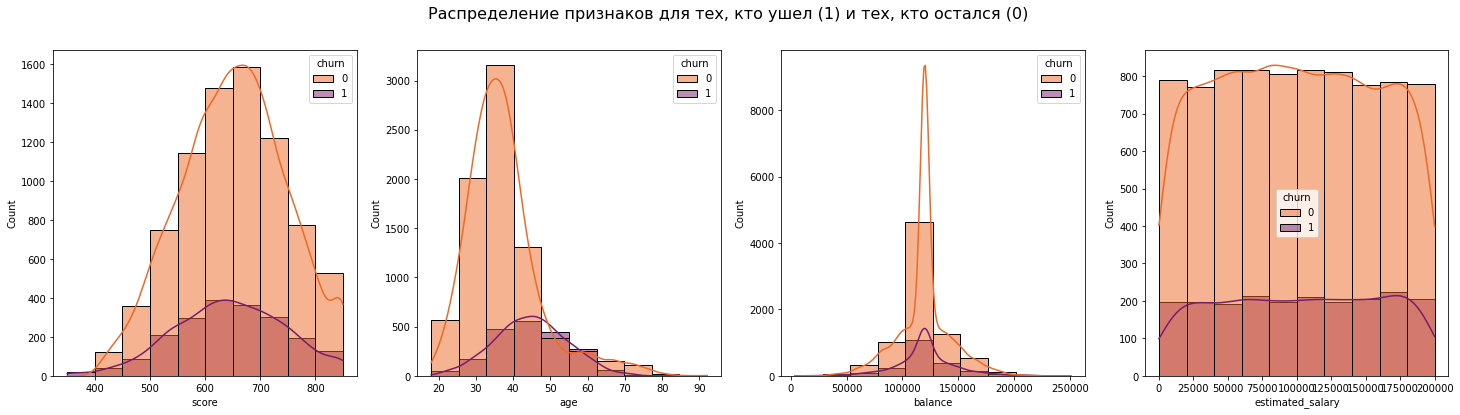

In [15]:
# построение гистограмм признаков для тех, кто ушел (1) и тех, кто остался (0)
df_hist = [
    'score',
    'age',
    'balance',
    'estimated_salary',
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25,6))
fig.suptitle('Распределение признаков для тех, кто ушел (1) и тех, кто остался (0)', fontsize=16)
for i in range(len(df_hist)):
    sns.histplot(df,
                 x = df_hist[i],
                 kde = True,
                 hue = 'churn',
                 bins = 10,
                 ax = axes.flatten()[i],
                 palette = 'inferno_r')

- График баллов кредитного скорринга распределен нормально со сдвигом вправо и для ушедших и для оставшихся клиентов;
- Необходимо проверить гипотезу о влиянии среднего балла кредитного скорринга на отток клиентов. Есть вероятность обнаружить неявную зависимость;
- Гистограмма возраста клиентов соответствует нормальному распределению с положительной асимметрией;
- Средний возраст ушедших клиентов выше;
- График баланса распределен нормально для каждой группы с пиковым значением 100 тыс.руб.;
- Гистограмма зарплат клиентов напоминает равномерное распределение для каждой группы, что довольно необычно.

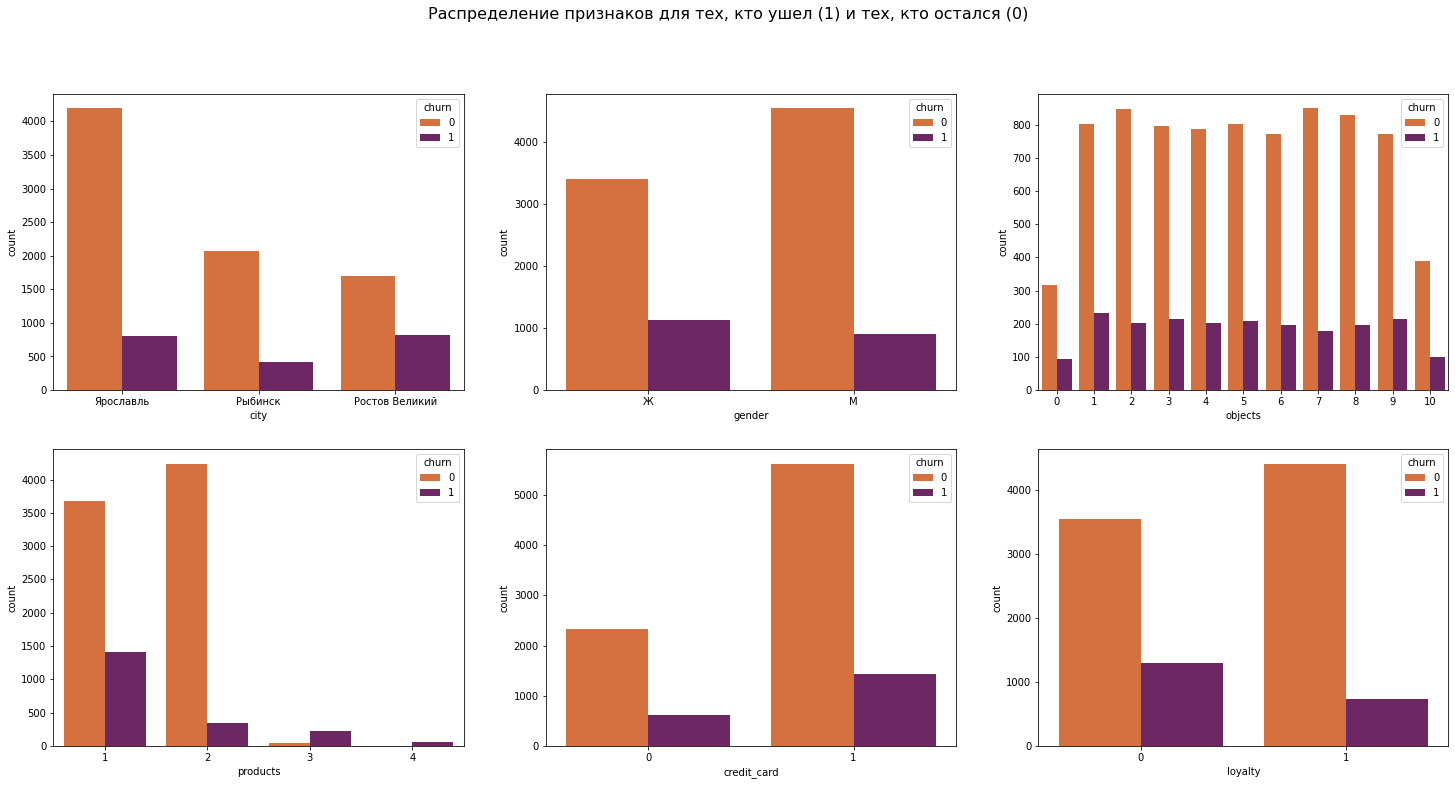

In [16]:
# построение гистограмм признаков для тех, кто ушел (1) и тех, кто остался (0)
df_bar = [
    'city',
    'gender',
    'objects',
    'products',
    'credit_card',
    'loyalty'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 12))
fig.suptitle('Распределение признаков для тех, кто ушел (1) и тех, кто остался (0)', fontsize=16)
for i in range(len(df_bar)):
    sns.countplot(data = df,
                  x = df_bar[i],
                  hue = 'churn',
                  ax = axes.flatten()[i],
                  palette = 'inferno_r')

In [17]:
# расчет доли оттока клиентов для каждого города
df.groupby('city')['churn'].mean().round(2)

city
Ростов Великий    0.32
Рыбинск           0.17
Ярославль         0.16
Name: churn, dtype: float64

In [18]:
# расчет доли оттока клиентов для каждого города в разбивке по гендеру
df.groupby(['city', 'gender'])['churn'].mean().round(2)

city            gender
Ростов Великий  Ж         0.38
                М         0.28
Рыбинск         Ж         0.21
                М         0.13
Ярославль       Ж         0.20
                М         0.13
Name: churn, dtype: float64

In [19]:
# расчет доли оттока клиентов, использующих разное количество продуктов банка
df.groupby('products')['churn'].agg(['count', 'sum', 'mean']).round(2)

,count,sum,mean
products,,,
1,5084,1409,0.28
2,4590,348,0.08
3,266,220,0.83
4,60,60,1.00


In [20]:
# анализ клиентов банка, использующих 3 или 4 продукта
d = df[(df['products'] == 3) | (df['products'] == 4)]
display(d.drop(columns={'user_id'}).groupby('churn').mean().T.round(2))
print('Количество клиентов с 3-мя или 4-мя продуктами:', d.user_id.count())

churn,0,1
score,670.04,645.67
age,37.30,44.70
objects,4.85,5.09
balance,119789.30,120137.47
products,3.00,3.21
credit_card,0.74,0.70
loyalty,0.61,0.41
estimated_salary,92560.21,106345.27


Количество клиентов с 3-мя или 4-мя продуктами: 326


In [21]:
# анализ влияния количества объектов в собственности на факт оттока
df.groupby('objects')['churn'].mean().round(2)

objects
0     0.23
1     0.22
2     0.19
3     0.21
4     0.21
5     0.21
6     0.20
7     0.17
8     0.19
9     0.22
10    0.21
Name: churn, dtype: float64

In [22]:
# расчет доли оттока клиентов в зависимости от наличия кредитной карты
df.groupby('credit_card')['churn'].mean().round(2)

credit_card
0    0.21
1    0.20
Name: churn, dtype: float64

In [23]:
# расчет доли оттока клиентов в зависимости от лояльности клиентов
df.groupby('loyalty')['churn'].mean().round(2)

loyalty
0    0.27
1    0.14
Name: churn, dtype: float64

**Вывод:**

- В городе Ростов Великий отток клиентов выше в 2 раза, чем в остальных городах; 
- Средний возраст ушедших клиентов выше: 45 лет вместо 37;
- В среднем для каждого города большему оттоку подвержены женщины, а в городе Ростов Великий этот показатель достигает 38%;
- Клиенты в 51% случаев пользуются одним продуктом и в 46% - двумя продуктами банка;
- Доля оттока клиентов, использующих один продукт банка составляет 28%, а использующих два продукта банка - 8%;
- Количество объектов в собственности не оказывает явного влияния на отток;
- Наличие кредитной карты не оказывает явного влияния на отток;
- У нелояльных клиентов отток выше в 2 раза.

Отдельное внимание вызывает уровень оттока тех клиентов, которые пользуются 3-мя или 4-мя продуктами банка: дебетовой картой, кредитной картой, вкладом, кредитом. 
<br>В первом случае отток составил 83%, во втором - 100%. Количество таких клиентов - 326 человек или 3%. 
<br>Анализ средних значений рассматриваемой группы не выявил аномалий относительно всего датасета, поэтому есть основание предположить, что отток сформировался случайным образом.

### Построение тепловой карты

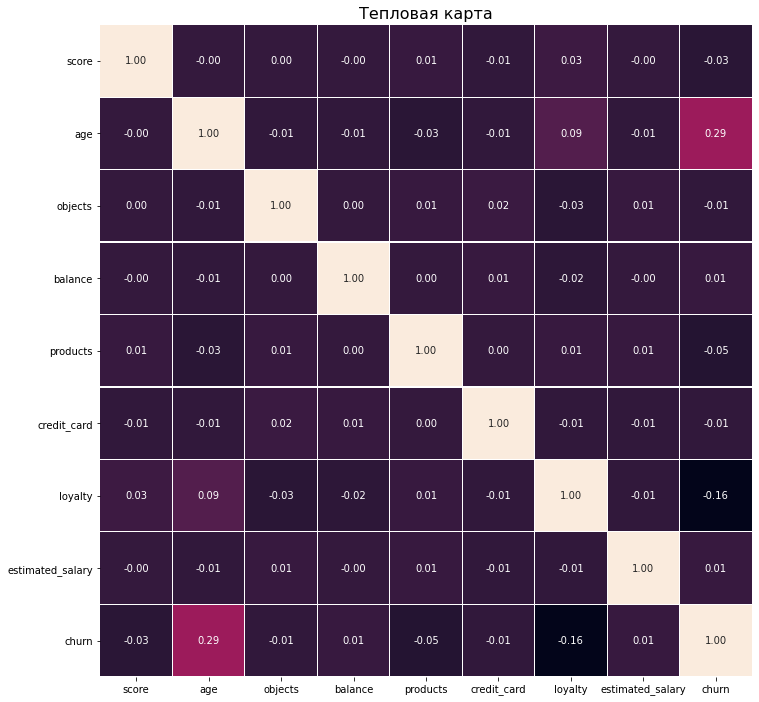

In [24]:
# построим тепловую карту
cm = df.drop(columns={'user_id'}).corr().round(2)

plt.figure(figsize=(12,12))
plt.title('Тепловая карта', fontsize=16)
sns.heatmap(cm, 
            annot = True, 
            square = True,  
            fmt = '0.2f', 
            cbar = False, 
            linewidths = .1);

Наблюдается положительная корреляция между возрастом и оттоком, однако ее влияние незначимо. 
<br>Кроме того, существует отрицательная корреляция между оттоком и лояльностью клиентов, но и она не обладает достаточной силой.

### Промежуточный вывод

Общая характеристика клиентов банка:
- Уровень оттока - 20%;
- Возрастная категория от 18 до 92 лет, средний возраст 39 лет;
- Средний доход - 100 тыс. руб.;
- 50% клиентов из города Ярославль и по 25% из городов Рыбинск и Ростов Великий;
- 45% клиентов - женщины, 55% - мужчины;
- Клиенты в 51% случаев пользуются одним продуктом и в 46% - двумя продуктами банка;
- Кредитной картой в среднем пользуется 70% клиентов;
- Значимой корреляции в данных не обнаружено.

Отличительные черты клиентов, склонных к оттоку:
- Клиенты из города Ростов Великий уходят в 32% случаев, в то время как в городах Ярославль и Рыбинск показатель составил 16% и 17% соответственно;
- Средний возраст ушедших клиентов выше: 45 лет вместо 37;
- Женщины в среднем уходят чаще мужчин, особенно в городе Ростов Великий, в котором показатель оттока у женщин составил 38%;
- Нелояльные клиенты в среднем подвержены оттоку в 27% случаев, при этом лояльные - в 14% случаев;
- Доля оттока клиентов, использующих один продукт банка составила 28%, а использующих два продукта банка - 8%.

## Проверка гипотез

### Сравнение средних доходов между действующими и ушедшими клиентами

**Проверка на равномерность распределения**

Из исследовательского анализа мы выяснили, что предполагаемая зарплата клиентов распределена равномерно. 
<br>Проверим это с помощью критерия Колмогорова-Смирнова. Критический уровень статистической значимости **alpha** примем на уровне **1%**.

In [25]:
alpha = 0.01

# эталонная выборка равномерного распределения 
# в интервале от 0 до 200 тыс. в количестве 10 тыс. повторений
data_1 = pd.Series(np.random.uniform(0, 200000, 10000))

# формирование двух независимых выборок
churned_salary = df.loc[df['churn'] == 1]['estimated_salary']
stayed_salary = df.loc[df['churn'] == 0]['estimated_salary']

# применение теста Колгоморова-Смирнова
print('Churned -', ks_2samp(data_1, churned_salary))
print('Stayed -', ks_2samp(data_1, stayed_salary))

Churned - KstestResult(statistic=0.02282906234658812, pvalue=0.3351973627947531)
Stayed - KstestResult(statistic=0.015052869521537109, pvalue=0.26415308058178594)


**Формирование и расчет гипотезы**

По итогу теста распределение зарплат действительно носит равномерный характер, поэтому для проведения А/Б-теста используем непараметрический критерий Манна-Уитни.

Сформулируем нулевую и альтернативную гипотезу:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средний доход действующих клиентов равен среднему доходу ушедших клиентов}\\
   H_1 :\text{Средний доход действующих клиентов отличается от среднего дохода ушедших клиентов}
 \end{cases}
\end{equation*}$

Критический уровень статистической значимости **alpha** оставим без изменений на уровне **1%**.

In [26]:
# формирование двух независимых выборок
churned_salary = df.loc[df['churn'] == 1]['estimated_salary']
stayed_salary = df.loc[df['churn'] == 0]['estimated_salary']

# проверка гипотезы о равенстве средних двух независимых совокупностей
first_hypo = st.mannwhitneyu(churned_salary, stayed_salary, alternative = 'two-sided')
print('p-value:', round(first_hypo.pvalue, 3))

# сравнение фактическое p-значение с заданным уровнем статистической значимости
if first_hypo.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.227
Не получилось отвергнуть нулевую гипотезу


In [27]:
# проверка расчетов
print('Средний доход ушедших клиентов =', round(churned_salary.mean(), 2),\
     '\nСредний доход действующих клиентов =', round(stayed_salary.mean(), 2),\
     '\nАбсолютная разница =', round((churned_salary.mean() - stayed_salary.mean()), 2),\
     '\nОтносительная разница =', round((((churned_salary.mean() - stayed_salary.mean()) / stayed_salary.mean()) * 100), 2), '%')

Средний доход ушедших клиентов = 101465.68 
Средний доход действующих клиентов = 99738.39 
Абсолютная разница = 1727.29 
Относительная разница = 1.73 %


**Вывод**

В результате расчета А/Б-теста принимается нулевая гипотеза, а значит различие в среднем доходе между ушедшими и действующими клиентами статистически незначимо. 

### Сравнение среднего балла кредитного скорринга между действующими и ушедшими клиентами

**Проверка на нормальность распределения**

Проверим распределение баллов на нормальность между теми, кто ушел и теми, кто остался. 
<br>Для этого применим критерий Шапиро-Уилка и построим QQ-график.

In [28]:
# формирование двух независимых выборок
churned_score = df.loc[df['churn'] == 1]['score']
stayed_score = df.loc[df['churn'] == 0]['score']

# применение теста Шапиро-Уилка для выявление нормальности распределения
print('Churned -', st.shapiro(churned_score))
print('Stayed -', st.shapiro(stayed_score))

Churned - ShapiroResult(statistic=0.993703305721283, pvalue=1.2323278042458696e-07)
Stayed - ShapiroResult(statistic=0.9928671717643738, pvalue=1.469723138650797e-19)


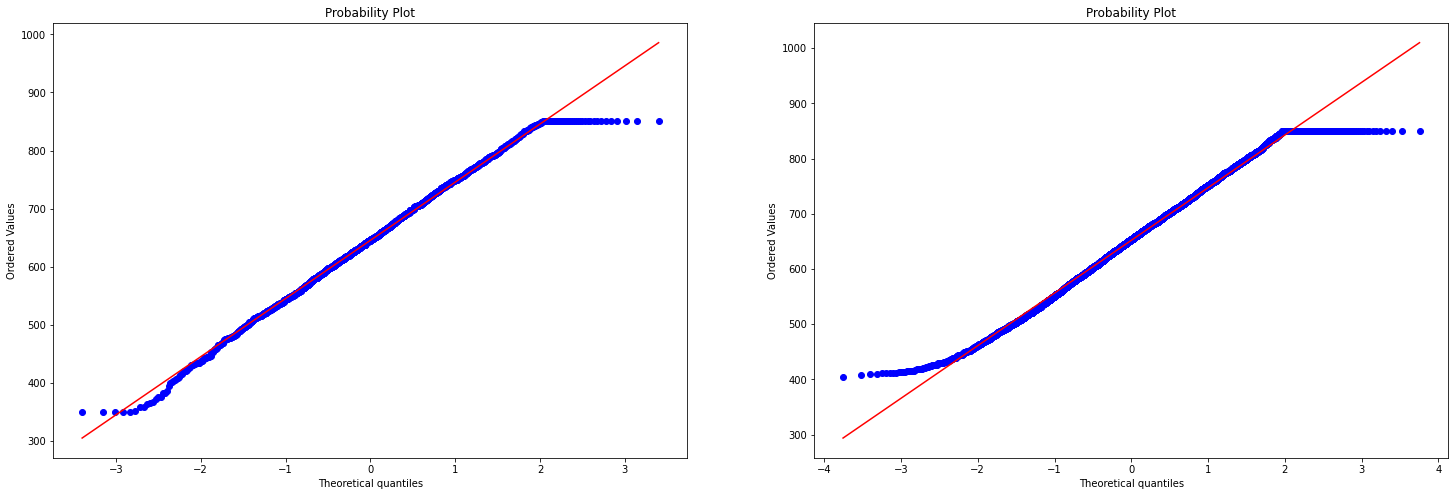

In [29]:
# QQ-график
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
st.probplot(churned_score, dist = "norm", plot = plt)
plt.subplot(1,2,2)
st.probplot(stayed_score, dist = "norm", plot = plt);

**Формирование и расчет гипотезы**

По итогу теста распределение баллов не является нормальным, поэтому для проведения А/Б-теста снова используем непараметрический критерий Манна-Уитни.

Сформулируем нулевую и альтернативную гипотезу:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Средний балл кредитного скорринга между действующими и ушедшими клиентами одинаковый}\\
   H_1 :\text{Средний балл кредитного скорринга ушедших клиентов ниже среднего балла действующих клиентов}
 \end{cases}
\end{equation*}$

Критический уровень статистической значимости **alpha** оставим без изменений на уровне **1%**.

In [30]:
# проверка гипотезы о равенстве средних двух независимых совокупностей
second_hypo = st.mannwhitneyu(churned_score, stayed_score, alternative = 'less')
print('p-value:', round(second_hypo.pvalue, 5))

# сравнение фактическое p-значение с заданным уровнем статистической значимости
if second_hypo.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.00993
Отвергаем нулевую гипотезу


In [31]:
# проверка расчетов
print('Средний балл ушедших клиентов =', round(churned_score.mean(), 2), \
     '\nСредний балл действующих клиентов =', round(stayed_score.mean(), 2), \
     '\nАбсолютная разница =', round((churned_score.mean() - stayed_score.mean()), 2), \
     '\nОтносительная разница =', round((((churned_score.mean() - stayed_score.mean()) / stayed_score.mean()) * 100), 2), '%')

Средний балл ушедших клиентов = 645.35 
Средний балл действующих клиентов = 651.85 
Абсолютная разница = -6.5 
Относительная разница = -1.0 %


**Вывод**

В результате проведения второго А/Б-теста отвергается нулевая гипотеза и принимается альтернативная. Таким образом, для ушедших клиентов вероятность получить средний балл кредитного скорринга в размере 652 составляет 1% и менее. Довольно редко событие.

### Сравнение доли действующих клиентов, имеющих и не имеющих кредитную карту

В качестве проверки используем **Z-критерий Фишера**, так как существуют две группы, для каждой из которых есть число попыток (количество клиентов в группе) и число успехов (количество действующих клиентов).

Сформулируем нулевую и альтернативную гипотезу:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Доли действующих клиентов, имеющих и не имеющих кредитную карту равны}\\
   H_1 :\text{Доли действующих клиентов, имеющих и не имеющих кредитную карту отличаются}
 \end{cases}
\end{equation*}$

Критический уровень статистической значимости **alpha** оставим без изменений на уровне **1%**.

In [32]:
# количество успехов и количество попыток для клиентов с кредитной картой
success_card = df[(df['churn'] == 0) & (df['credit_card'] == 1)]['credit_card'].count()
trials_card = df[df['credit_card'] == 1]['credit_card'].count()

print('Количество действующих клиентов с кредитной картой -', success_card, \
         '\nОбщее количество клиентов с кредитной картой -', trials_card, \
         '\nДоля -', round((success_card / trials_card), 2))

Количество действующих клиентов с кредитной картой - 5631 
Общее количество клиентов с кредитной картой - 7055 
Доля - 0.8


In [33]:
# количество успехов и количество попыток для клиентов без кредитной карты
success_no_card = df[(df['churn'] == 0) & (df['credit_card'] == 0)]['credit_card'].count()
trials_no_card = df[df['credit_card'] == 0]['credit_card'].count()

print('Количество действующих клиентов без кредитной картой -', success_no_card, \
         '\nОбщее количество клиентов без кредитной картой -', trials_no_card, \
         '\nДоля -', round((success_no_card / trials_no_card), 2))

Количество действующих клиентов без кредитной картой - 2332 
Общее количество клиентов без кредитной картой - 2945 
Доля - 0.79


In [34]:
# проверка гипотезы о равенстве долей двух независимых совокупностей
successes = np.array([success_card, success_no_card])
trials = np.array([trials_card, trials_no_card])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value.round(2))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-value:  0.48
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод**

В результате расчета третьего А/Б-теста принимается нулевая гипотеза с **p_value** равной **0.48** при установленной **alpha - 0.01**, а значит, наличие кредитной карты не влияет на отток клиентов банка.

### Промежуточный вывод

В ходе проверки трёх статистических гипотез выявлено:
1. Средняя предполагаемая зарплата между действующими и ушедшими клиентами одинаковая;
2. Средний балл кредитного скорринга ушедших клиентов ниже среднего балла оставшихся клиентов;
3. Наличие кредитной карты не влияет на удержание или отток клиентов.

## Заключение

### Вывод

Исходные данные состоят из 12 столбцов и 10 тысяч строк, типы данных указаны верно, явных дубликатов не обнаружено. В результате предобработки названия колонок приведены в соответствие стилистике Python. Для заполнения пропусков в столбце 'balance' потребовалось создать дополнительный столбец, который присвоил каждому клиенту один из четырех классов в зависимости от предполагаемой зарплаты. В итоге пропуски заполнены медианой исходя из принадлежности клиента к классу, потому как столбец с зарплатой представлен в денежном выражении и мог иметь аномальные значения. 

Дополнительно отмечу высокую долю пропусков в столбце с балансом - 36% - без явных на то причин. Необходимо сообщить о находке дата инженерам для внесения корректировок.


В ходе исследовательского анализа получена общая характеристика клиентов банка:
- Уровень оттока - 20%;
- Возрастная категория от 18 до 92 лет, средний возраст 39 лет;
- Средний доход - 100 тыс. руб.;
- 50% клиентов из города Ярославль и по 25% из городов Рыбинск и Ростов Великий;
- 45% клиентов - женщины, 55% - мужчины;
- Клиенты в 51% случаев пользуются одним продуктом и в 46% - двумя продуктами банка;
- Кредитной картой пользуется 70% клиентов;
- Значимой корреляции в данных не обнаружено.


Отличительные черты клиентов, склонных к оттоку, и рекомендации на их основе:
- Клиенты из города Ростов Великий уходят в 32% случаев, в то время как в городах Ярославль и Рыбинск показатель составил 16% и 17% соответственно. Причиной большого оттока в Ростове может являться низкое качество обслуживания клиентов. Рекомендуется проверить оценку работы персонала и провести обучение;
- Средний возраст ушедших клиентов выше: 45 лет вместо 37. Это может быть связано с отсутствием обучающей вводной части сайта и приложения, подсказок в интерфейсе, оперативного реагирования на вопросы клиентов. Рекомендуется проверить удобство использования продуктов, сделать интуитивно понятный дизайн, добавить обучающую часть и всегда быть готовым придти на помощь в кратчайший срок по любому удобному клиентом каналу связи;
- Женщины в среднем уходят чаще мужчин, особенно в городе Ростов Великий, в котором показатель оттока у женщин составил 38%. Вероятно, это также связано с низким качеством обслуживания в кассах. Рекомендуется воспользоваться услугами тайного покупателя, преимущественно женского пола;
- Нелояльные клиенты в среднем подвержены оттоку в 27% случаев, при этом лояльные - в 14% случаев. Причиной высокого уровня оттока нелояльных клиентов может являться потеря интереса к продукту. Рекомендуется выстроить регулярную коммуникацию для повышения лояльности, например: делать еженедельную рассылку по одному или нескольким каналам связи на тему финансов, последних новостей и их влиянии. Некоторые банки в стране пошли еще дальше и создали журналы, форумы, сообщества на самые разные темы, где люди делятся своим опытом и задают вопросы экспертам. Это - яркий пример борьбы за внимание и активной работы над удержанием клиента;
- Доля оттока клиентов, использующих один продукт, составила 28%, а использующих два продукта - 8%. Скорее всего клиенты не нашли для себя выгодное предложение. Для решения этой проблемы рекомендуется периодически проводить акции, челленджи и розыгрыши.


В ходе проверки трёх статистических гипотез дополнительно выявлено:
- Средняя предполагаемая зарплата между действующими и ушедшими клиентами одинаковая;
- Средний балл кредитного скорринга ушедших клиентов ниже среднего балла оставшихся клиентов;
- Наличие кредитной карты не влияет на удержание или отток клиентов.

### Рекомендации

В качестве дополнительных рекомендаций можно предложить:
- Исследовать отзывы клиентов из города Ростов Великий, в том числе собрать информацию с популярных сервисов для отзывов, а также отзывы с Яндекс.Карт, Гугл.Карт и 2GIS;
- Запустить краткий опрос клиентов, включающий оценку удобства оказания услуги по 5-бальной шкале и возможность оставить комментарий или пожелание на 500 символов;
- Определить источники привлечения клиентов и добавить этот признак в таблицу для анализа. Такой способ поможет определить эффективные каналы привлечения и сделать акцент;
- Столбец с количеством продуктов может быть еще полезнее, если на каждый вид продукта выделить отдельный столбец. Тогда появится возможность не только анализировать отток по каждому виду, но и предлагать клиентам другие продукты банка;
- Проанализировать структуру сайта и приложения. Возможно, получится сделать процесс оказания услуг еще проще, быстрее и удобнее для клиента;
- Внести мониторинг сигналов оттока. Например: предлагать индивидуальные предложения клиентам, склонным к оттоку;
- Поощрять самых ценных клиентов, они должны чаще получать персонализированную коммуникацию, подарки и скидки. Также VIP-аудитории нравится, когда их обслуживает персональный менеджер и оказывает всестороннюю поддержку.

Это только часть рекомендаций по удержанию, где основная цель - внимание каждому клиенту.